In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

import scipy.io
from fastbook import *
from fastai.vision.widgets import *
from collections import defaultdict

Mounted at /content/gdrive


Load the path and the .mat files with the relevant metadata

In [ ]:
path     = untar_data('http://ai.stanford.edu/~jkrause/cars/car_devkit.tgz')
Path.BASE_PATH = path
path_pic = untar_data('https://s3.amazonaws.com/fast-ai-imageclas/stanford-cars.tgz')

In [ ]:
mat_ctrain  = scipy.io.loadmat(path/'cars_train_annos.mat')
mat_ctest   = scipy.io.loadmat(path/'cars_test_annos.mat')
mat_meta    = scipy.io.loadmat(path/'cars_meta.mat')

Create a defaultdict which contains all file names and the corresponding class 

In [ ]:
num_of_pic = len(mat_ctrain['annotations'][0])
classes    = defaultdict()

for i in range(num_of_pic):

    direction = "/root/.fastai/data/stanford-cars/cars_train/"
    picture   = mat_ctrain['annotations'][0][i][5][0]
    model_num = mat_ctrain['annotations'][0][i][4][0][0]
    model     = mat_meta['class_names'][0][model_num-1][0]

    classes[direction + picture] = model

Create a DataBlock. Note the get_y function calls the classname through the defaultdict

In [ ]:

cars = DataBlock(blocks     = (ImageBlock, CategoryBlock),
                 get_items  = get_image_files, 
                 splitter   = RandomSplitter(seed=42),
                 get_y      = lambda x: classes[str(x)],
                 item_tfms  = Resize(460),
                 batch_tfms = aug_transforms(size=224, min_scale=0.75))

Load the data and verify that my method for dataloading worked

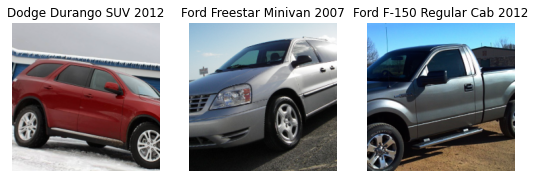

In [ ]:
dls      = cars.dataloaders(path_pic/'cars_train') 
dls.show_batch(nrows=1, ncols=3)

Train the NN

In [ ]:
learn = cnn_learner(dls, resnet34, metrics = error_rate)
learn.fine_tune(10)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch,train_loss,valid_loss,error_rate,time
0,6.001437,4.101210,0.865479,02:37


epoch,train_loss,valid_loss,error_rate,time
0,4.305242,3.459351,0.776413,03:03
1,3.544990,2.659990,0.631450,03:02
2,2.760553,2.040146,0.519656,03:03
3,2.036383,1.693498,0.444717,03:03
4,1.512763,1.365107,0.366093,03:02
5,1.123309,1.204726,0.328010,03:02
6,0.859424,1.050660,0.289312,03:02
7,0.679775,0.995727,0.280098,03:02
8,0.549219,0.978524,0.273342,03:02
9,0.499114,0.967948,0.272727,03:02


Create a ClassificationInterpretation

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)


Here we can see all classes which were confused more than 3 times

In [ ]:
interp.most_confused(min_val=3)

[('GMC Savana Van 2012', 'Chevrolet Express Van 2007', 6),
 ('Aston Martin Virage Convertible 2012',
  'Aston Martin V8 Vantage Convertible 2012',
  5),
 ('Dodge Caliber Wagon 2012', 'Dodge Caliber Wagon 2007', 5),
 ('Aston Martin V8 Vantage Coupe 2012',
  'Aston Martin V8 Vantage Convertible 2012',
  3),
 ('Audi 100 Wagon 1994', 'Audi V8 Sedan 1994', 3),
 ('Audi TT Hatchback 2011', 'Audi TTS Coupe 2012', 3),
 ('Audi TTS Coupe 2012', 'Audi TT Hatchback 2011', 3),
 ('Chevrolet Silverado 1500 Extended Cab 2012',
  'Chevrolet Silverado 2500HD Regular Cab 2012',
  3),
 ('Chevrolet Silverado 1500 Regular Cab 2012',
  'Chevrolet Silverado 1500 Hybrid Crew Cab 2012',
  3),
 ('Ferrari California Convertible 2012',
  'Ferrari 458 Italia Convertible 2012',
  3),
 ('HUMMER H2 SUT Crew Cab 2009', 'HUMMER H3T Crew Cab 2010', 3),
 ('Volvo C30 Hatchback 2012', 'Jaguar XK XKR 2012', 3)]

Here are some results:

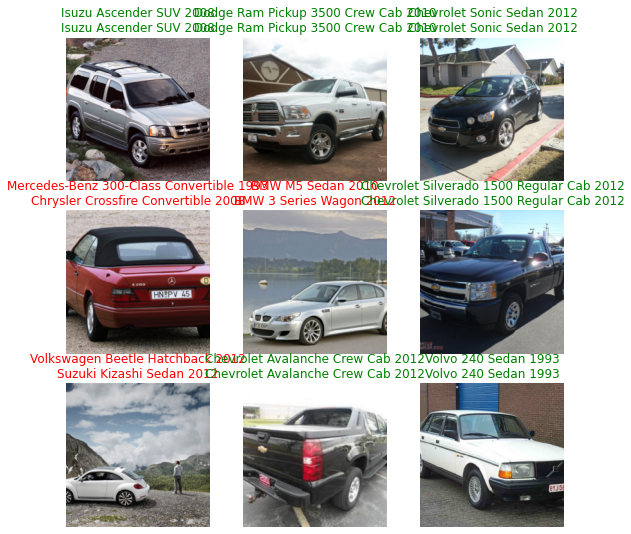

In [ ]:
learn.show_results()

Now I will try to find a better learning rate

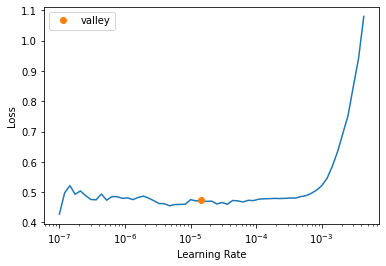

In [ ]:
lr = learn.lr_find()

In [ ]:
lr

SuggestedLRs(valley=1.4454397387453355e-05)

However, the model did not improve

In [ ]:
learn = cnn_learner(dls, resnet34, metrics = error_rate)
learn.fine_tune(3, base_lr=1.4454397387453355e-05)

epoch,train_loss,valid_loss,error_rate,time
0,7.139271,5.987997,0.995700,02:39


epoch,train_loss,valid_loss,error_rate,time
0,7.134750,5.967856,0.997543,03:04
1,7.125241,5.939457,0.994472,03:03
2,7.067326,5.936858,0.995700,03:03
